# Preparations

### Import libraries

Import standard libraries we need for interaction with data - Numpy and Pandas, for visualization - Matplotlib and Seaborn, for getting financial data - yfinance and pandas_datareader.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas_datareader.data as web

Import the main functionality we need from the pypfopt library to implement the Efficient Frontier technique.

In [6]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting #in plotting.py plt.style.use("seaborn-deep") replaced by plt.style.use("seaborn-v0_8-deep")
from pypfopt.base_optimizer import portfolio_performance

### Create time boundaries

Creating variables with time boundaries using the datetime library.

In [9]:
import datetime

end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

We have the customer portfolio consisting of 13 different stocks with actual weights in it.

In [12]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate Efficient Frontier and portfolios

### Load the stock data

Take the rate of U.S. 10 Year Treasury as the risk free rate.

In [16]:
gs10 = web.DataReader('GS10', 'fred', start_date, end_date)
riskfreerate = gs10.iloc[-1]['GS10']/100

Load the daily stock data within the 5-year time period by using yfinance. We use adjusted price because we are interested in considering dividends.

In [18]:
stock_data = yf.download(portfolio, start_date, end_date, interval='1d')
stock_data = stock_data['Adj Close']

[*********************100%***********************]  13 of 13 completed


Get mean return and covariance matrix by using pypfopt functions.

In [20]:
mu = mean_historical_return(stock_data, compounding=False)
cov = sample_cov(stock_data)

We aim to achieve a highly diversified portfolio by setting both minimum and maximum percentage limits, ensuring that each stock's allocation falls within this range in the final portfolio.

In [22]:
min_stock_fraction = 1/(portfolio_len*2)
max_stock_fraction = 2/portfolio_len

### Calculate Efficient Frontier

Get the Efficient Frontier for out portfolio with weights boundaries.

In [25]:
ef = EfficientFrontier(mu, cov, weight_bounds=(min_stock_fraction, max_stock_fraction))

### Calculate portfolios

Get the portfolio with maximum Sharpe Ratio - the tangency portfolio.

In [28]:
ef_max_sharpe = ef.deepcopy()
ef_max_sharpe.max_sharpe(risk_free_rate=riskfreerate)
ret_tangent, std_tangent, sharpe_tangent = ef_max_sharpe.portfolio_performance(verbose=True)

Expected annual return: 20.8%
Annual volatility: 22.6%
Sharpe Ratio: 0.75


Get the performance of current portfolio.

In [30]:
ret_current, std_current, sharpe_current = portfolio_performance(current_weights, mu, cov, verbose=True, risk_free_rate=riskfreerate)

Expected annual return: 18.6%
Annual volatility: 23.1%
Sharpe Ratio: 0.64


### Generate random portfolios

In [32]:
n_samples = 5000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = (rets - riskfreerate) / stds

# Results

### Draw results

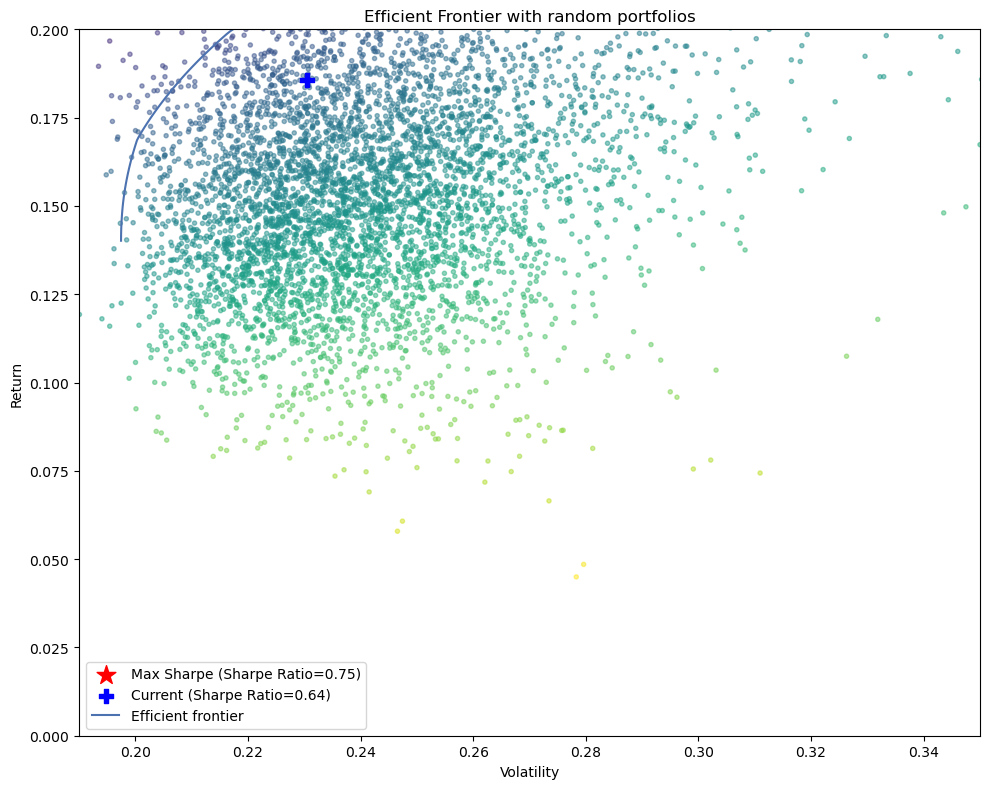

In [35]:
fig, ax = plt.subplots()
ax.set_xlim([0.19, 0.35])
ax.set_ylim([0, 0.20])

# Random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r", alpha=0.5)

# The tangency portfolio
ax.scatter(std_tangent, ret_tangent, marker="*", s=200, c="r", label=f"Max Sharpe (Sharpe Ratio={round(sharpe_tangent, 2)})")

# The current portfolio
ax.scatter(std_current, ret_current, marker="P", s=100, c="b", label=f"Current (Sharpe Ratio={round(sharpe_current, 2)})")

# The Efficient Frontier
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False, color='r')

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

We limited the graph axes for better visualization. We are focused on certain portfolios and an efficient frontier and don't need extreme random portfolios to see. Some random portfolios show both return and volatility better than portfolios from the efficient frontier. That is because for an efficient frontier, we have strong restricted bounds for possible weights. Results show that we can improve both return and volatility, and can maximize the Sharpe Ratio compared to the current portfolio.

### Print portfolios weights

In [38]:
ef_max_sharpe_cleaned_weights = list(ef_max_sharpe.clean_weights().values())

In [39]:
current_portfolio = pd.DataFrame(current_weights, index=portfolio, columns=['Current weights'])
max_sharpe_ratio_random_portfolio = pd.DataFrame(ef_max_sharpe_cleaned_weights, index=portfolio, columns=['Max sharpe ratio weights'])

portfolios = pd.concat([current_portfolio, max_sharpe_ratio_random_portfolio], axis=1)

portfolios

,Current weights,Max sharpe ratio weights
AAPL,0.1269,0.15385
ABBV,0.1082,0.15385
BAC,0.0473,0.03846
BTI,0.0762,0.07720
C,0.0441,0.03846
CMCSA,0.0627,0.03846
FDX,0.1069,0.15278
GPS,0.1006,0.03925
HPQ,0.0716,0.15385
INTC,0.0401,0.03846


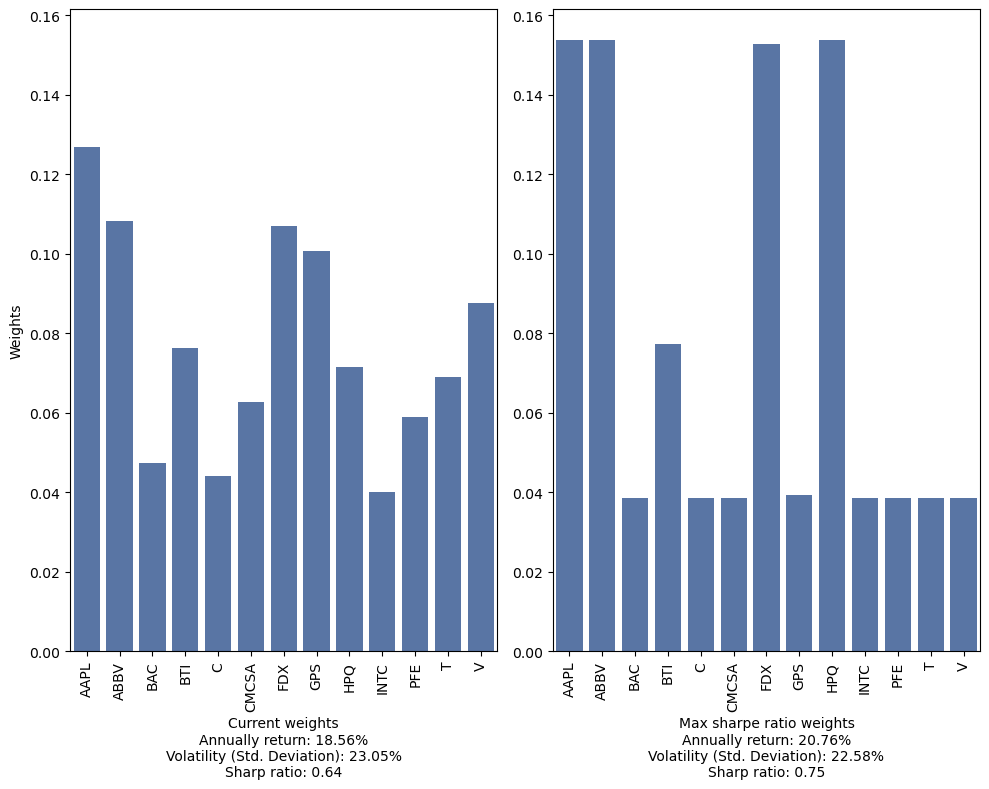

In [40]:
ax1 = plt.subplot(1,2,1)
sns.barplot(x=portfolios.index, y=portfolios['Current weights'])
plt.ylabel("Weights");
plt.xlabel(f"""Current weights
Annually return: {round(ret_current*100,2)}%
Volatility (Std. Deviation): {round(std_current*100,2)}%
Sharp ratio: {round(sharpe_current,2)}""");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(1,2,2)
ax2.sharey(ax1)
sns.barplot(x=portfolios.index, y=portfolios['Max sharpe ratio weights'])
plt.ylabel("");
plt.xlabel(f"""Max sharpe ratio weights
Annually return: {round(ret_tangent*100,2)}%
Volatility (Std. Deviation): {round(std_tangent*100,2)}%
Sharp ratio: {round(sharpe_tangent,2)}""");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()